**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.71978897 -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200275 -0.9999998 ]
 [-0.12210423  0.6280527   0.9671843  -0.9937122  -0.25839362]
 [ 0.9999983  -0.9999994  -0.9999975  -0.8594331  -0.9999881 ]
 [ 0.99928284 -0.99999803 -0.9999058   0.9857963  -0.92205757]]


## Using `static_rnn()`

**Note**: `tf.contrib.rnn` was partially moved to the core API in TensorFlow 1.2. Most of the `*Cell` and `*Wrapper` classes are now available in `tf.nn.rnn_cell`, and the `tf.contrib.rnn.static_rnn()` function is available as `tf.nn.static_rnn()`.

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, [X0, X1],
                                       dtype=tf.float32)
Y0, Y1 = output_seqs

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.06679279, -0.9999803 ,  0.99982214],
       [-0.65249425, -0.51520866, -0.37968954, -0.5922594 , -0.08968391],
       [ 0.998624  , -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

In [13]:
from tensorflow_graph_in_jupyter import show_graph

In [14]:
show_graph(tf.get_default_graph())

## Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs,
                                       dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999999 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971031  -0.9964609 ]
  [-0.637116    0.11300932  0.5798437   0.43105596 -0.63716984]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987185 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191977  0.7827872   0.9525682  -0.9781773 ]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999999 ]
 [-0.637116    0.11300932  0.5798437   0.43105596 -0.63716984]
 [-0.9165386  -0.9945604   0.896054    0.99987185 -0.9999751 ]
 [-0.02746338 -0.73191977  0.7827872   0.9525682  -0.9781773 ]]


## Using `dynamic_rnn()`

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [23]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [25]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.9999959   0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.8522789   0.5845349  -0.7878095 ]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.9999999  -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.36009568  0.7624866   0.99817705  0.80142003]]]


In [26]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [27]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [28]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

Instructions for updating:
Use tf.cast instead.


In [29]:
init = tf.global_variables_initializer()

In [30]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [31]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [32]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.9567258   0.9983168   0.99970174  0.9651857 ]]

 [[-0.9998612   0.6702291   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.96135855  0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [33]:
print(states_val)

[[-1.          0.9567258   0.9983168   0.99970174  0.9651857 ]
 [-0.9998612   0.6702291   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.96135855  0.9568762   0.7132288   0.97729224 -0.0958299 ]]


## Training a sequence classifier

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.


**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [35]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [36]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [37]:
X_test = X_test.reshape((-1, n_steps, n_inputs))

In [40]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.9533333 Test accuracy: 0.9288
1 Last batch accuracy: 0.96 Test accuracy: 0.9472
2 Last batch accuracy: 0.96 Test accuracy: 0.9502
3 Last batch accuracy: 0.96666664 Test accuracy: 0.954
4 Last batch accuracy: 0.97333336 Test accuracy: 0.9656
5 Last batch accuracy: 0.94 Test accuracy: 0.9664
6 Last batch accuracy: 0.9866667 Test accuracy: 0.9554
7 Last batch accuracy: 0.96 Test accuracy: 0.9717
8 Last batch accuracy: 0.9866667 Test accuracy: 0.9652
9 Last batch accuracy: 0.99333334 Test accuracy: 0.9709
10 Last batch accuracy: 0.97333336 Test accuracy: 0.9714
11 Last batch accuracy: 0.98 Test accuracy: 0.977
12 Last batch accuracy: 0.94666666 Test accuracy: 0.9709
13 Last batch accuracy: 0.96666664 Test accuracy: 0.9757
14 Last batch accuracy: 0.99333334 Test accuracy: 0.9735
15 Last batch accuracy: 0.97333336 Test accuracy: 0.9716
16 Last batch accuracy: 1.0 Test accuracy: 0.9789
17 Last batch accuracy: 1.0 Test accuracy: 0.9759
18 Last batch accuracy: 0.9933333

# Multi-layer RNN

In [41]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [42]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [43]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [44]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.94666666 Test accuracy: 0.9381
1 Last batch accuracy: 0.96666664 Test accuracy: 0.966
2 Last batch accuracy: 0.96666664 Test accuracy: 0.9719
3 Last batch accuracy: 0.9866667 Test accuracy: 0.9738
4 Last batch accuracy: 0.98 Test accuracy: 0.9735
5 Last batch accuracy: 0.96666664 Test accuracy: 0.9767
6 Last batch accuracy: 0.99333334 Test accuracy: 0.9815
7 Last batch accuracy: 0.97333336 Test accuracy: 0.9788
8 Last batch accuracy: 0.99333334 Test accuracy: 0.9767
9 Last batch accuracy: 0.97333336 Test accuracy: 0.9791


# Time series

In [45]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


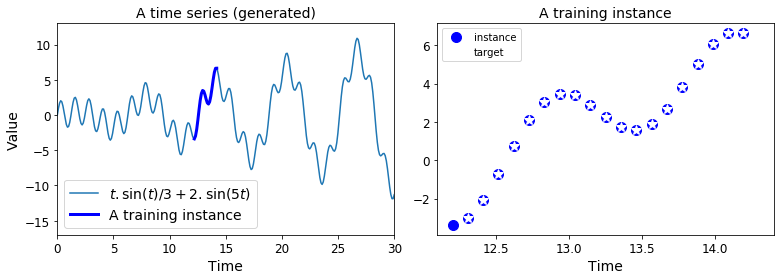

In [46]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [47]:
X_batch, y_batch = next_batch(1, n_steps)

In [48]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [49]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [50]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [51]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [52]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [53]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [54]:
saver = tf.train.Saver()

In [55]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 10.261381
100 	MSE: 0.38783535
200 	MSE: 0.10971393
300 	MSE: 0.06142948
400 	MSE: 0.059208594
500 	MSE: 0.057419535
600 	MSE: 0.052253913
700 	MSE: 0.046964772
800 	MSE: 0.04941703
900 	MSE: 0.047623064
1000 	MSE: 0.047578864
1100 	MSE: 0.046452977
1200 	MSE: 0.04004542
1300 	MSE: 0.046569455
1400 	MSE: 0.041250996


In [56]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [57]:
y_pred

array([[[-3.4015713 ],
        [-2.4648154 ],
        [-1.065511  ],
        [ 0.69048625],
        [ 2.145151  ],
        [ 3.110319  ],
        [ 3.4750142 ],
        [ 3.3476262 ],
        [ 2.7957058 ],
        [ 2.2065432 ],
        [ 1.671819  ],
        [ 1.5209379 ],
        [ 1.8635523 ],
        [ 2.7135623 ],
        [ 3.8195097 ],
        [ 5.0859127 ],
        [ 6.092083  ],
        [ 6.6383862 ],
        [ 6.6529365 ],
        [ 6.0492744 ]]], dtype=float32)

Saving figure time_series_pred_plot


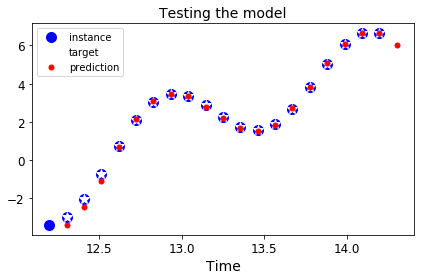

In [58]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [59]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [60]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [61]:
n_outputs = 1
learning_rate = 0.001

In [62]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [63]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [64]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907031
100 	MSE: 0.50563276
200 	MSE: 0.1972298
300 	MSE: 0.1026313
400 	MSE: 0.067478806
500 	MSE: 0.06297704
600 	MSE: 0.05659878
700 	MSE: 0.050051264
800 	MSE: 0.0505437
900 	MSE: 0.04874706
1000 	MSE: 0.04847027
1100 	MSE: 0.050347283
1200 	MSE: 0.041849542
1300 	MSE: 0.05084179
1400 	MSE: 0.043897416


In [65]:
y_pred

array([[[-3.4289923],
        [-2.4533434],
        [-1.0973964],
        [ 0.7335469],
        [ 2.2075677],
        [ 3.0849245],
        [ 3.4615984],
        [ 3.369708 ],
        [ 2.8800738],
        [ 2.2592   ],
        [ 1.7156593],
        [ 1.5570309],
        [ 1.9206175],
        [ 2.782949 ],
        [ 3.9346495],
        [ 5.164315 ],
        [ 6.1489983],
        [ 6.6907682],
        [ 6.663847 ],
        [ 6.0862308]]], dtype=float32)

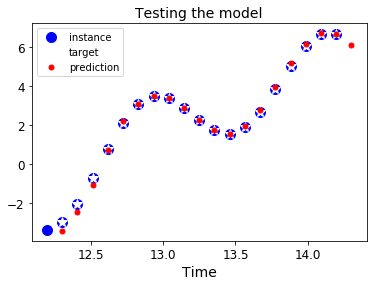

In [66]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [67]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


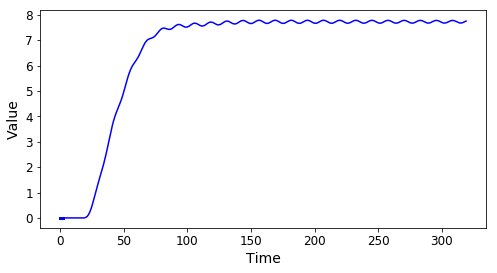

In [68]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


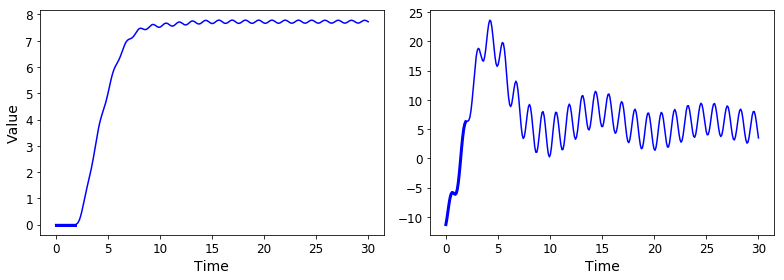

In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [70]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [71]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [72]:
init = tf.global_variables_initializer()

In [73]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [74]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [75]:
outputs_val.shape

(2, 5, 100)

## Distributing a Deep RNN Across Multiple GPUs

Do **NOT** do this:

In [76]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

Instead, you need a `DeviceCellWrapper`:

In [77]:
import tensorflow as tf

class DeviceCellWrapper(tf.nn.rnn_cell.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [78]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [79]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Alternatively, since TensorFlow 1.1, you can use the `tf.contrib.rnn.DeviceWrapper` class (alias `tf.nn.rnn_cell.DeviceWrapper` since TF 1.2).

In [80]:
init = tf.global_variables_initializer()

In [81]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-4.64021787e-02 -1.09517202e-01  1.15719393e-01 ... -2.52173133e-02
    1.18367799e-01  2.02370673e-01]
  [ 8.25042576e-02 -2.59060264e-01  1.70650586e-01 ...  1.27473503e-01
    2.67642260e-01  5.00117093e-02]
  [-4.02192712e-01 -5.05355299e-01  9.59846973e-02 ...  2.13280901e-01
    2.34671846e-01  4.09884661e-01]
  ...
  [-2.83994704e-01 -7.33134806e-01  3.17926139e-01 ...  3.41021776e-01
    4.12628204e-01 -6.32287189e-02]
  [ 2.27203682e-01 -7.05208600e-01  1.00495324e-01 ... -1.41650066e-01
    5.51967025e-01  5.99662587e-02]
  [-6.84873387e-03 -5.12680411e-01 -2.85935104e-01 ... -2.31354401e-01
    2.07134143e-01  8.85490328e-02]]

 [[-5.23373708e-02 -8.67693499e-02  8.17485303e-02 ... -1.00591466e-01
    1.27385408e-01  1.19344600e-01]
  [ 9.99870598e-02 -1.82395414e-01  2.22275108e-02 ...  1.32248059e-01
    2.45662898e-01  1.98356793e-04]
  [-3.53575259e-01 -4.52652425e-01  1.14802465e-01 ... -7.28872791e-02
    1.18325420e-01  2.53719807e-01]
  ...
  [-5.62219083e-01 -5.4

## Dropout

In [82]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [83]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

Note: the `input_keep_prob` parameter can be a placeholder, making it possible to set it to any value you want during training, and to 1.0 during testing (effectively turning dropout off). This is a much more elegant solution than what was recommended in earlier versions of the book (i.e., writing your own wrapper class or having a separate model for training and testing). Thanks to Shen Cheng for bringing this to my attention.

In [84]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [85]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 15.983469
100 Training MSE: 4.9558105
200 Training MSE: 3.959256
300 Training MSE: 4.2868385
400 Training MSE: 3.1707375
500 Training MSE: 3.7190058
600 Training MSE: 4.0965495
700 Training MSE: 4.141506
800 Training MSE: 4.0747395
900 Training MSE: 4.31458
1000 Training MSE: 3.8041306
1100 Training MSE: 3.9771643
1200 Training MSE: 2.9983945
1300 Training MSE: 3.212077
1400 Training MSE: 3.9303396


In [87]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


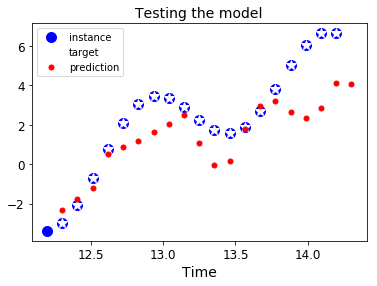

In [88]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

# LSTM

In [89]:
reset_graph()

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [90]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [91]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [92]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [93]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.97333336 Test accuracy: 0.9564
1 Last batch accuracy: 0.96 Test accuracy: 0.9723
2 Last batch accuracy: 0.9533333 Test accuracy: 0.9629
3 Last batch accuracy: 0.99333334 Test accuracy: 0.9831
4 Last batch accuracy: 0.99333334 Test accuracy: 0.985
5 Last batch accuracy: 0.9866667 Test accuracy: 0.983
6 Last batch accuracy: 1.0 Test accuracy: 0.9863
7 Last batch accuracy: 0.99333334 Test accuracy: 0.9859
8 Last batch accuracy: 1.0 Test accuracy: 0.9872
9 Last batch accuracy: 0.99333334 Test accuracy: 0.9865


In [94]:
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, use_peepholes=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [95]:
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [96]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [97]:
words = fetch_words_data()

In [98]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [99]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [100]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [101]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [102]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [103]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [104]:
np.random.seed(42)

In [105]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [106]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [107]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [108]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [109]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [110]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [111]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [112]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [113]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.90948486328125
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, egyptians, richards, legionnaires, opener, leonel,
Nearest to up: clair, drives, steadfas

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [114]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [115]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

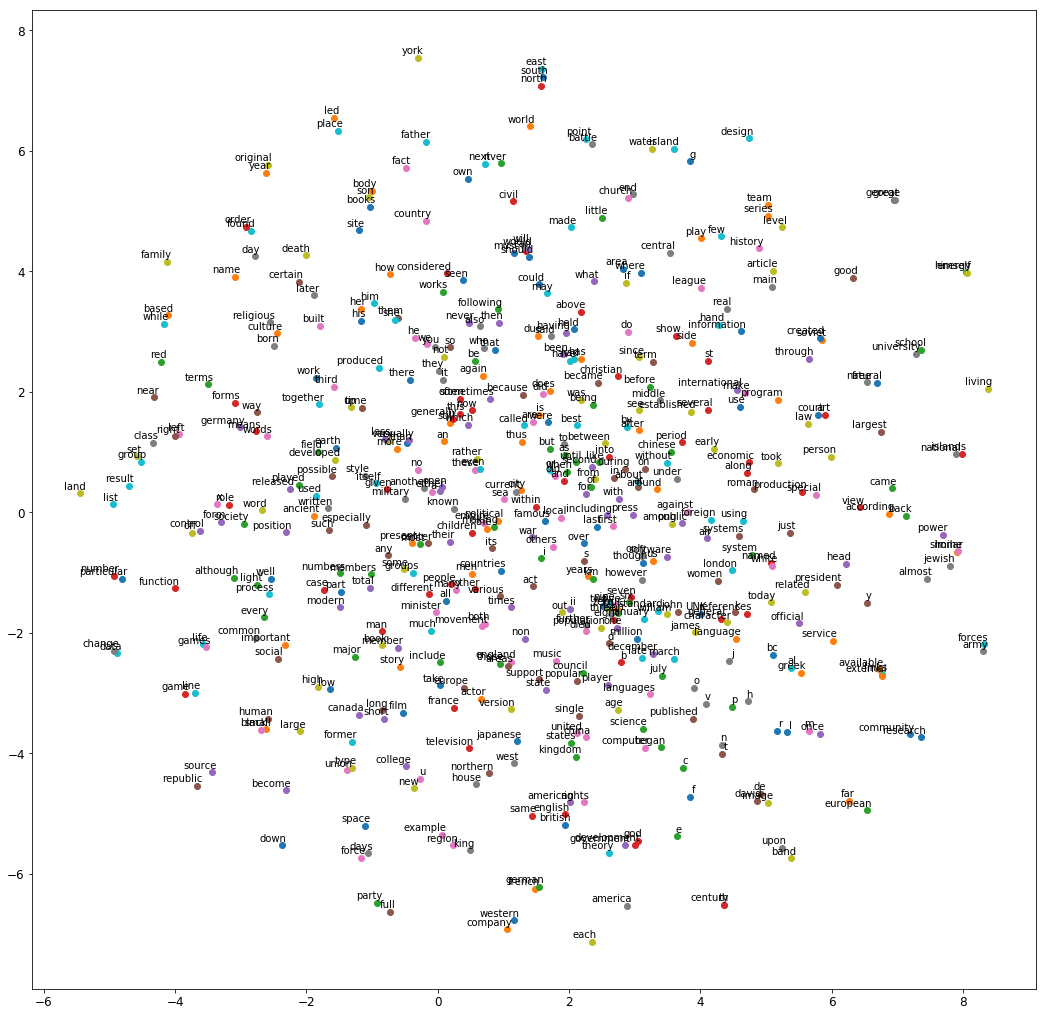

In [116]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [117]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [118]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

## 1. to 6.

See Appendix A.

## 7. Embedded Reber Grammars

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [119]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [120]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [121]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [122]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [123]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

It's not possible to feed a string directly to an RNN: we need to convert it to a sequence of vectors, first. Each vector will represent a single letter, using a one-hot encoding. For example, the letter "B" will be represented as the vector `[1, 0, 0, 0, 0, 0, 0]`, the letter E will be represented as `[0, 1, 0, 0, 0, 0, 0]` and so on. Let's write a function that converts a string to a sequence of such one-hot vectors. Note that if the string is shorted than `n_steps`, it will be padded with zero vectors (later, we will tell TensorFlow how long each string actually is using the `sequence_length` parameter).

In [124]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [125]:
string_to_one_hot_vectors("BTBTXSETE", 12)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [126]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [127]:
X_train, l_train, y_train = generate_dataset(10000)

Let's take a look at the first training instances:

In [128]:
X_train[0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0,

It's padded with a lot of zeros because the longest string in the dataset is that long. How long is this particular string?

In [129]:
l_train[0]

23

What class is it?

In [130]:
y_train[0]

array([0])

Perfect! We are ready to create the RNN to identify good strings. We build a sequence classifier very similar to the one we built earlier to classify MNIST images, with two main differences:
* First, the input strings have variable length, so we need to specify the `sequence_length` when calling the `dynamic_rnn()` function.
* Second, this is a binary classifier, so we only need one output neuron that will output, for each input string, the estimated log probability that it is a good string. For multiclass classification, we used `sparse_softmax_cross_entropy_with_logits()` but for binary classification we use `sigmoid_cross_entropy_with_logits()`.


In [131]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's generate a validation set so we can track progress during training:

In [132]:
X_val, l_val, y_val = generate_dataset(5000)

In [133]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./my_reber_classifier")

   0  Train loss: 0.6727, accuracy: 66.00%  Validation accuracy: 59.34%
   1  Train loss: 0.6553, accuracy: 68.00%  Validation accuracy: 61.82%
   2  Train loss: 0.6200, accuracy: 76.00%  Validation accuracy: 72.50%
   3  Train loss: 0.4908, accuracy: 82.00%  Validation accuracy: 73.22%
   4  Train loss: 0.4223, accuracy: 84.00%  Validation accuracy: 79.72%
   5  Train loss: 0.3864, accuracy: 88.00%  Validation accuracy: 85.38%
   6  Train loss: 0.5302, accuracy: 76.00%  Validation accuracy: 78.96%
   7  Train loss: 0.5804, accuracy: 78.00%  Validation accuracy: 77.38%
   8  Train loss: 0.3122, accuracy: 86.00%  Validation accuracy: 89.14%
   9  Train loss: 0.1790, accuracy: 94.00%  Validation accuracy: 93.52%
  10  Train loss: 0.1354, accuracy: 98.00%  Validation accuracy: 95.00%
  11  Train loss: 0.3055, accuracy: 90.00%  Validation accuracy: 88.56%
  12  Train loss: 0.2447, accuracy: 92.00%  Validation accuracy: 91.62%
  13  Train loss: 0.0677, accuracy: 100.00%  Validation accuracy

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [134]:
test_strings = [
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "./my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba_val[index][0]))

INFO:tensorflow:Restoring parameters from ./my_reber_classifier

Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.01%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.97%


Ta-da! It worked fine. The RNN found the correct answers with high confidence. :)

## 8. and 9.

Coming soon...